Choose Block-2 solver: [1] Brute force, [2] DVQE (distributed):  1


Running ADMM with Brute-force batch solver...
Iter   0 | status=           optimal | residual: 1.0671e+01
Iter  10 | status=           optimal | residual: 1.4146e+00
Iter  20 | status=           optimal | residual: 8.1106e-02
Iter  30 | status=           optimal | residual: 1.1837e-02
Iter  40 | status=           optimal | residual: 6.1667e-03
Iter  50 | status=           optimal | residual: 4.1499e-03
Iter  60 | status=           optimal | residual: 2.9564e-03
Iter  70 | status=           optimal | residual: 2.2051e-03
Iter  80 | status=           optimal | residual: 1.6809e-03
Iter  90 | status=           optimal | residual: 1.2982e-03
Iter 100 | status=           optimal | residual: 9.8831e-04


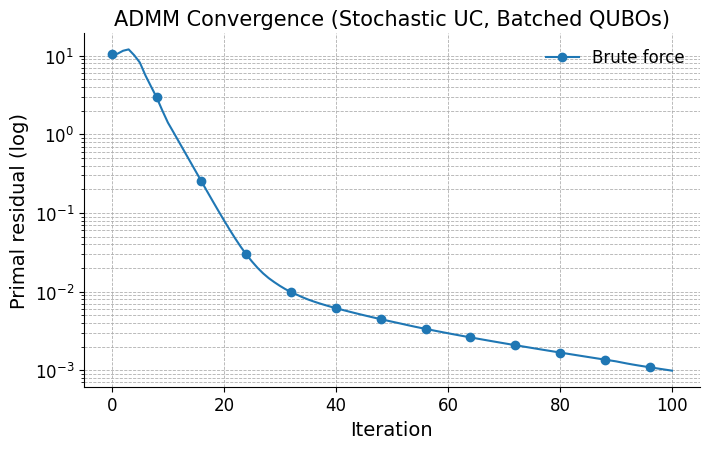

Saved figure: "admm_convergence.jpg"

% === LaTeX table for Brute-force run ===

\begin{table}[!t]
\scriptsize
\setlength{\tabcolsep}{3pt}
\renewcommand{\arraystretch}{1.2}
\captionsetup{font={footnotesize}}
\caption{Partial Dispatch for Medium-Scale UC ($N{=}20$, $T{=}24$). Ten representative units over first six hours.}
\centering
\begin{tabular}{c|cccccccccc|c|c}
\hline
\multirow{2}{*}{\textbf{t}} & \multicolumn{10}{c|}{\textbf{Unit Dispatch $p_i$ (MW)}} & \multirow{2}{*}{$\sum_i p_{i,t}$} & \multirow{2}{*}{$L_t$} \\ \cline{2-11}
& $p_1$ & $p_3$ & $p_4$ & $p_6$ & $p_7$ & $p_{10}$ & $p_{12}$ & $p_{15}$ & $p_{18}$ & $p_{20}$ & & \\ \hline
1 & 0.0 & 70.0 & -0.0 & 70.0 & 85.0 & 60.0 & 0.0 & 85.0 & 70.0 & 80.0 & 900.0 & 900.0 \\ \hline
2 & 0.0 & 100.0 & -0.0 & 40.0 & 40.0 & 30.0 & 0.0 & 40.0 & 100.0 & 110.0 & 950.0 & 950.0 \\ \hline
3 & 33.3 & 70.0 & 0.0 & 30.0 & 35.0 & 30.0 & 50.0 & 35.0 & 130.0 & 70.0 & 1000.0 & 1000.0 \\ \hline
4 & 76.7 & 40.0 & 20.0 & 30.0 & 35.0 & 30.0 & 90.0 & 35.0

In [3]:
# ===========================================
# Unified ADMM (UC) with selectable Block-2 solver:
#   1) Brute force micro/batch QUBOs
#   2) DVQE (distributed) for batch QUBOs
#
# Batch-level "accept-if-better" policy is applied for both.
# Plots residuals and saves "admm_convergence.jpg".
# Also prints a LaTeX-ready partial dispatch table.
# ===========================================

import numpy as np
import cvxpy as cp
import math
import matplotlib.pyplot as plt
from itertools import product

# ===== Optional (only needed for DVQE mode) =====
try:
    from raiselab import DVQE
except Exception:
    DVQE = None

# -------------------------------
# Choose solver (interactive)
# -------------------------------
choice = input("Choose Block-2 solver: [1] Brute force, [2] DVQE (distributed): ").strip()
if choice not in {"1", "2"}:
    raise ValueError("Please enter '1' for Brute force or '2' for DVQE.")

USE_DVQE = (choice == "2")
if USE_DVQE and DVQE is None:
    raise RuntimeError("DVQE package not found. Install/enable raiselab or choose option 1.")

# -------------------------------
# Switches / verbosity
# -------------------------------
USE_BATCH_IN_UPDATES      = True   # update z using accepted batch solution
DEBUG_COMPARE_BATCH_MICRO = False
VERBOSE_BATCH_LOG         = False
ITERPRINT                 = 10
ACCEPT_TOL_BATCH          = 1e-12  # numerical cushion in accept-if-better

# -------------------------------
# Grouped Batch-QUBO controls
# -------------------------------
K_BATCHES          = 10
HARD_EPS_ENERGY    = 1e-6
HARD_ETA           = 1e-9
HARD_WEIGHTS       = dict(w1=1.0, w2=1.0, w3=1.0, w4=1.0, w5=1.0)

# -------------------------------
# DVQE config (only used if USE_DVQE=True)
# -------------------------------
dvqe_mode = "distributed"   # <- per request
dvqe_depth = 2
dvqe_lr = 0.1
dvqe_max_iters = 100
qpu_qubit_config = [3, 3, 3, 3, 3]  # example qubit grouping (5 mini-QPUs)

# -------------------------------
# QUBO helpers
# -------------------------------
def solve_qubo_brute_force(Q, q_linear):
    Q = np.asarray(Q, dtype=float)
    q = np.asarray(q_linear, dtype=float).ravel()
    n = q.size
    if Q.shape != (n, n):
        raise ValueError(f"Q must have shape ({n},{n}), got {Q.shape}")
    Q = 0.5 * (Q + Q.T)
    best_z, best_cost = None, float("inf")
    for cand in product([0, 1], repeat=n):
        z = np.fromiter(cand, dtype=float, count=n)
        cost = z @ Q @ z + q @ z
        if cost < best_cost:
            best_cost = cost
            best_z = z.astype(int)
    return best_z, best_cost

def enumerate_energy(Q, c):
    Q = 0.5 * (Q + Q.T)
    out = []
    for cand in product([0, 1], repeat=3):
        z = np.array(cand, dtype=float)
        E = float(z @ Q @ z + c @ z)
        out.append((cand, E))
    return out

def hardness_score(Q, c, eps_energy_scale=1.0, weights=HARD_WEIGHTS):
    spec = enumerate_energy(Q, c)
    Es = sorted([E for _, E in spec])
    Emin = Es[0]
    Delta = Es[1] - Emin if len(Es) > 1 else float('inf')
    epsE = HARD_EPS_ENERGY * eps_energy_scale
    g_eps = sum(1 for E in Es if E <= Emin + epsE)

    Q12, Q23, Q13 = Q[0,1], Q[1,2], Q[0,2]
    prod_sign = np.sign(Q12 * Q23 * Q13)
    frustrated = 1 if prod_sign < 0 else 0

    coup = abs(Q12) + abs(Q23) + abs(Q13)
    field = abs(c[0]) + abs(c[1]) + abs(c[2]) + 1e-16
    r = coup / field

    coeffs = [abs(Q12), abs(Q23), abs(Q13), abs(c[0]), abs(c[1]), abs(c[2])]
    nz = [x for x in coeffs if x > 0]
    if len(nz) == 0:
        dr = 0.0
    else:
        M, m = max(nz), min(nz)
        dr = math.log10(M / m) if M > 0 and m > 0 else 0.0

    w1, w2, w3, w4, w5 = weights["w1"], weights["w2"], weights["w3"], weights["w4"], weights["w5"]
    score = (
        w1 * (1.0 / (Delta + HARD_ETA)) +
        w2 * ((g_eps - 1.0) / 7.0) +
        w3 * (1.0 * frustrated) +
        w4 * (r / (1.0 + r)) +
        w5 * (dr / 4.0)
    )
    return float(score), dict(Delta=Delta, g_eps=g_eps, frustrated=frustrated, r=r, dr=dr)

def build_unit_batches_at_time_t(N, Q_list_t, c_list_t, k_batches=K_BATCHES):
    k_batches = max(1, min(k_batches, N))
    hard_i = np.zeros(N, dtype=float)
    items = []
    for i in range(N):
        Q, c = Q_list_t[i], c_list_t[i]
        scale = (np.sum(np.abs(Q)) + np.sum(np.abs(c)) + 1.0)
        score, _ = hardness_score(Q, c, eps_energy_scale=scale)
        hard_i[i] = score
        items.append((i, score))
    # sort by difficulty and greedy bin-pack to balance hardness
    items.sort(key=lambda x: x[1], reverse=True)
    batches = [[] for _ in range(k_batches)]
    batch_scores = [0.0 for _ in range(k_batches)]
    for i, score in items:
        b = int(np.argmin(batch_scores))
        batches[b].append(i)
        batch_scores[b] += score
    sizes = [len(b) for b in batches]
    return batches, batch_scores, sizes, hard_i

# Micro-QUBO builder
def micro_qubo_coeffs(qy, qu, qv, y_hat, u_hat, v_hat, y_ref,
                      gamma_c, gamma_ss, gamma_u2y, gamma_v2ny,
                      gamma_y, gamma_u, gamma_v):
    """Return (Q,c) for 3-bit micro-QUBO over [z^y, z^u, z^v]."""
    Q = np.zeros((3,3), dtype=float)  # [y u v]
    c = np.array([qy, qu, qv], dtype=float)

    # anchors
    c[0] += gamma_y * (1 - 2 * y_hat)
    c[1] += gamma_u * (1 - 2 * u_hat) + gamma_u2y
    c[2] += gamma_v * (1 - 2 * v_hat)

    # local (c): (zy - zu + zv - y_ref)^2
    c[0] += gamma_c * (1 - 2 * y_ref)
    c[1] += gamma_c * (1 + 2 * y_ref)
    c[2] += gamma_c * (1 - 2 * y_ref)
    Q[0,1] += -2 * gamma_c; Q[1,0] = Q[0,1]
    Q[0,2] += +2 * gamma_c; Q[2,0] = Q[0,2]
    Q[1,2] += -2 * gamma_c; Q[2,1] = Q[1,2]

    # no simultaneous u+v
    Q[1,2] += gamma_ss; Q[2,1] = Q[1,2]

    # start -> on
    Q[0,1] += -gamma_u2y; Q[1,0] = Q[0,1]

    # shutdown -> off
    Q[0,2] += gamma_v2ny; Q[2,0] = Q[0,2]

    return Q, c

def local_augL_alone(y_it, u_it, v_it, sy_it, su_it, sv_it,
                     lamy_it, lamu_it, lamv_it, zy, zu, zv,
                     rho_y, rho_u, rho_v):
    Ly = lamy_it * (y_it - zy + sy_it) + 0.5 * rho_y * (y_it - zy + sy_it)**2
    Lu = lamu_it * (u_it - zu + su_it) + 0.5 * rho_u * (u_it - zu + su_it)**2
    Lv = lamv_it * (v_it - zv + sv_it) + 0.5 * rho_v * (v_it - zv + sv_it)**2
    return float(Ly + Lu + Lv)

def assemble_batch_qubo(units, Q_list, c_list):
    """Concatenate 3x3 blocks [y,u,v] per unit (no cross couplings)."""
    m = len(units)
    Qb = np.zeros((3*m, 3*m), dtype=float)
    cb = np.zeros(3*m, dtype=float)
    for k, i in enumerate(units):
        Qb[3*k:3*k+3, 3*k:3*k+3] = Q_list[i]
        cb[3*k:3*k+3] = c_list[i]
    return Qb, cb

# -------------------------------
# Problem data (deterministic) — N=20, T=24
# -------------------------------
N = 20
T = 24

rng = np.random.default_rng(11)

# Costs
A = np.array([500,520,540,560,580,600,620,640,660,680,
              700,720,740,760,780,800,820,840,860,880], dtype=float)
B = np.array([20,21,22,23,24,25,26,27,28,29,
              30,19,18,22,24,26,20,21,22,23], dtype=float)
C = np.array([0.0020,0.0021,0.0022,0.0023,0.0024,
              0.0018,0.0019,0.0020,0.0021,0.0022,
              0.0023,0.0024,0.0025,0.0020,0.0019,
              0.0018,0.0022,0.0023,0.0024,0.0025], dtype=float)
S = np.array([200,210,220,230,240,250,260,270,280,290,
              300,200,220,240,260,280,300,320,340,360], dtype=float)
H = np.zeros(N, dtype=float)

# Capacities
Pmin = np.array([20,25,30,20,25,30,35,20,25,30,
                 40,20,25,30,35,20,25,30,35,40], dtype=float)
Pmax = np.array([100,120,140,100,120,140,160,100,120,140,
                 180,100,120,140,160,100,120,140,160,180], dtype=float)

# Ramps
RU = np.array([40,35,30,40,35,30,45,40,35,30,
               50,40,35,30,45,40,35,30,45,40], dtype=float)
RD = np.array([40,35,30,40,35,30,45,40,35,30,
               50,40,35,30,45,40,35,30,45,40], dtype=float)
SU = RU + 10
SD = RD + 10

# Min up/down
Umin = np.array([2,2,3,2,3,2,3,2,3,2,
                 2,3,2,3,2,3,2,3,2,3], dtype=int)
Dmin = np.array([2,2,2,3,2,3,2,3,2,3,
                 2,2,3,2,3,2,3,2,3,2], dtype=int)

# Demand profile (MW), smooth 24h curve
L = np.array([
 900, 950,1000,1050,1100,1150,1200,1250,
1300,1350,1400,1450,1500,1450,1400,1350,
1300,1250,1200,1150,1100,1050,1000, 950], dtype=float)

# Reserve requirements
R_up_req = np.array([60,65,70,70,75,80,85,85,90,95,95,100,
                     100,95,90,85,80,75,70,70,65,65,60,60], dtype=float)
R_dn_req = np.array([55,55,60,60,65,65,70,70,75,75,80,80,
                     80,75,75,70,70,65,65,60,60,55,55,55], dtype=float)

delta_tau = 1.0

# -------------------------------
# ADMM runner
# -------------------------------
def run_admm(USE_DVQE=False):
    # Hyperparameters per mode
    rho_y = rho_u = rho_v = 2.0e6
    beta_y = beta_u = beta_v = 2.0e6
    epsilon = 1e-3
    max_iter = 4000

    # Micro-QUBO penalties (scaled to rho_y)
    gamma_c      = 0.20 * rho_y   # local (c) balance
    gamma_ss     = 0.10 * rho_y   # discourage u & v both 1
    gamma_u2y    = 0.05 * rho_y   # start implies on
    gamma_v2ny   = 0.05 * rho_y   # shutdown implies off
    gamma_y = gamma_u = gamma_v = 0.10 * rho_y  # anchors to Block-1

    # init
    p0 = np.ones(N)* 40
    y0 = (p0 > 0.0).astype(int)

    y = np.ones((N, T)) * 0.5
    u = np.zeros((N, T))
    v = np.zeros((N, T))
    p = np.tile(L / max(N, 1), (N, 1))
    r_up = np.zeros((N, T))
    r_dn = np.zeros((N, T))

    z_y = np.zeros((N, T), dtype=int)
    z_u = np.zeros((N, T), dtype=int)
    z_v = np.zeros((N, T), dtype=int)
    s_y = np.zeros((N, T))
    s_u = np.zeros((N, T))
    s_v = np.zeros((N, T))

    lam_y = np.zeros((N, T))
    lam_u = np.zeros((N, T))
    lam_v = np.zeros((N, T))
    primal_residuals = []

    for it in range(max_iter):
        # ========= Block 1: Classical QP =========
        yi  = cp.Variable((N, T))
        ui  = cp.Variable((N, T))
        vi  = cp.Variable((N, T))
        pi  = cp.Variable((N, T))
        rup = cp.Variable((N, T), nonneg=True)
        rdn = cp.Variable((N, T), nonneg=True)

        econ = (
            cp.sum(cp.multiply(A[:, None], yi)) +
            cp.sum(cp.multiply(B[:, None], pi)) +
            cp.sum(cp.multiply(C[:, None], cp.square(pi))) +
            cp.sum(cp.multiply(S[:, None], ui)) +
            cp.sum(cp.multiply(H[:, None], vi))
        )
        pen_y = cp.sum(cp.multiply(lam_y, yi - z_y + s_y)) + (rho_y / 2) * cp.sum_squares(yi - z_y + s_y)
        pen_u = cp.sum(cp.multiply(lam_u, ui - z_u + s_u)) + (rho_u / 2) * cp.sum_squares(ui - z_u + s_u)
        pen_v = cp.sum(cp.multiply(lam_v, vi - z_v + s_v)) + (rho_v / 2) * cp.sum_squares(vi - z_v + s_v)
        objective = cp.Minimize(econ + pen_y + pen_u + pen_v)

        cons = []
        cons += [yi >= 0, yi <= 1, ui >= 0, ui <= 1, vi >= 0, vi <= 1]
        cons += [pi >= 0]
        for t in range(T):
            cons += [cp.sum(pi[:, t]) == L[t]]
        cons += [pi >= cp.multiply(Pmin[:, None], yi)]
        cons += [pi <= cp.multiply(Pmax[:, None], yi)]
        cons += [yi[:, 0] - y0 == ui[:, 0] - vi[:, 0]]
        cons += [ui[:, 0] + vi[:, 0] <= 1]
        for t in range(1, T):
            cons += [yi[:, t] - yi[:, t-1] == ui[:, t] - vi[:, t]]
            cons += [ui[:, t] + vi[:, t] <= 1]
        for i in range(N):
            Ui, Di = int(Umin[i]), int(Dmin[i])
            for t in range(T):
                k_up = max(0, t - Ui + 1)
                k_dn = max(0, t - Di + 1)
                cons += [cp.sum(ui[i, k_up:t+1]) <= yi[i, t]]
                cons += [cp.sum(vi[i, k_dn:t+1]) <= 1 - yi[i, t]]
        for i in range(N):
            cons += [pi[i, 0] - p0[i] <= RU[i] * y0[i] + SU[i] * ui[i, 0]]
            cons += [p0[i] - pi[i, 0] <= RD[i] * yi[i, 0] + SD[i] * vi[i, 0]]
            for t in range(1, T):
                cons += [pi[i, t] - pi[i, t-1] <= RU[i] * yi[i, t-1] + SU[i] * ui[i, t]]
                cons += [pi[i, t-1] - pi[i, t] <= RD[i] * yi[i, t]   + SD[i] * vi[i, t]]
        cons += [rup <= cp.multiply(Pmax[:, None], yi) - pi]
        cons += [rdn <= pi - cp.multiply(Pmin[:, None], yi)]
        cons += [rup <= RU[:, None] * delta_tau]
        cons += [rdn <= RD[:, None] * delta_tau]
        for t in range(T):
            cons += [cp.sum(rup[:, t]) >= R_up_req[t]]
            cons += [cp.sum(rdn[:, t]) >= R_dn_req[t]]

        yi.value, ui.value, vi.value = y, u, v
        pi.value, rup.value, rdn.value = p, r_up, r_dn

        prob = cp.Problem(objective, cons)
        installed = set(cp.installed_solvers())
        status = "unknown"
        if "OSQP" in installed:
            prob.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8,
                       max_iter=1_600_000, polish=True, warm_start=True, verbose=False)
            status = prob.status
        if status not in ("optimal", "optimal_inaccurate") and "SCS" in installed:
            prob.solve(solver=cp.SCS, eps=5e-8, max_iters=2_000_000,
                       warm_start=True, verbose=False)
            status = prob.status

        y   = yi.value
        u   = ui.value
        v   = vi.value
        p   = pi.value
        r_up = rup.value
        r_dn = rdn.value

        # ========= Block 2: K batch-QUBOs per time t =========
        z_y_prev, z_u_prev, z_v_prev = z_y.copy(), z_u.copy(), z_v.copy()

        for t in range(T):
            # Base linear terms
            qy_vec = -(lam_y[:, t] + rho_y * (y[:, t] + s_y[:, t])) + 0.5 * rho_y
            qu_vec = -(lam_u[:, t] + rho_u * (u[:, t] + s_u[:, t])) + 0.5 * rho_u
            qv_vec = -(lam_v[:, t] + rho_v * (v[:, t] + s_v[:, t])) + 0.5 * rho_v

            Q_list_t, c_list_t = [None]*N, [None]*N
            for i in range(N):
                y_hat, u_hat, v_hat = y[i, t], u[i, t], v[i, t]
                y_ref = (z_y_prev[i, t-1] if t > 0 else y0[i])
                Q3, c3 = micro_qubo_coeffs(qy_vec[i], qu_vec[i], qv_vec[i],
                                           y_hat, u_hat, v_hat, y_ref,
                                           gamma_c, gamma_ss, gamma_u2y, gamma_v2ny,
                                           gamma_y, gamma_u, gamma_v)
                Q_list_t[i] = Q3
                c_list_t[i] = c3

            # Partition into K batches
            batches_t, batch_scores_t, batch_sizes_t, hard_i = build_unit_batches_at_time_t(
                N, Q_list_t, c_list_t, k_batches=K_BATCHES
            )
            if VERBOSE_BATCH_LOG and it % ITERPRINT == 0:
                print(f"[Block-2] Iter {it}: t={t+1} -> {len(batches_t)} batch-QUBOs")
                for b in range(len(batches_t)):
                    print(f"   t={t+1} Batch {b+1}: size={batch_sizes_t[b]:2d}, "
                          f"hardness_sum={batch_scores_t[b]:.3e}")

            # Solve batches and accept-if-better (batch-level)
            for b, units in enumerate(batches_t):
                n_units = len(units)
                Qb = np.zeros((3*n_units, 3*n_units))
                cb = np.zeros(3*n_units)
                for k, i in enumerate(units):
                    Q3, c3 = Q_list_t[i], c_list_t[i]
                    idx = slice(3*k, 3*k+3)
                    Qb[idx, idx] = Q3
                    cb[idx] = c3

                if USE_DVQE:
                    Qb = 0.5 * (Qb + Qb.T)
                    zb, _, _ = DVQE(mode=dvqe_mode, Q=Qb, q_linear=cb, init_type=2,
                                    depth=dvqe_depth, lr=dvqe_lr, max_iters=dvqe_max_iters,
                                    qpu_qubit_config=qpu_qubit_config, rel_tol=1e-6)
                    zb = np.asarray(zb, dtype=float).ravel()
                    zb = (zb >= 0.5).astype(int)
                else:
                    zb, _ = solve_qubo_brute_force(Qb, cb)
                    zb = np.asarray(zb, dtype=int).ravel()

                # 1) Unpack proposal
                proposed = []
                for k, i in enumerate(units):
                    zy_new, zu_new, zv_new = map(int, zb[3*k:3*k+3])
                    proposed.append((i, zy_new, zu_new, zv_new))

                # 2) Compare summed AL (before vs after)
                old_al_sum = 0.0
                new_al_sum = 0.0
                for (i, zy_new, zu_new, zv_new) in proposed:
                    old_al_sum += local_augL_alone(
                        y[i, t], u[i, t], v[i, t],
                        s_y[i, t], s_u[i, t], s_v[i, t],
                        lam_y[i, t], lam_u[i, t], lam_v[i, t],
                        z_y_prev[i, t], z_u_prev[i, t], z_v_prev[i, t],
                        rho_y, rho_u, rho_v
                    )
                    new_al_sum += local_augL_alone(
                        y[i, t], u[i, t], v[i, t],
                        s_y[i, t], s_u[i, t], s_v[i, t],
                        lam_y[i, t], lam_u[i, t], lam_v[i, t],
                        zy_new, zu_new, zv_new,
                        rho_y, rho_u, rho_v
                    )

                # 3) Accept entire batch only if total AL improves
                if new_al_sum + ACCEPT_TOL_BATCH <= old_al_sum:
                    for (i, zy_new, zu_new, zv_new) in proposed:
                        z_y[i, t], z_u[i, t], z_v[i, t] = zy_new, zu_new, zv_new
                else:
                    for (i, _, _, _) in proposed:
                        z_y[i, t], z_u[i, t], z_v[i, t] = z_y_prev[i, t], z_u_prev[i, t], z_v_prev[i, t]

        # ========= Block 3: Prox slacks + projection =========
        s_y = -(lam_y + rho_y * (y - z_y)) / (beta_y + rho_y)
        s_u = -(lam_u + rho_u * (u - z_u)) / (beta_u + rho_u)
        s_v = -(lam_v + rho_v * (v - z_v)) / (beta_v + rho_v)
        s_y = np.maximum(0.0, s_y)
        s_u = np.maximum(0.0, s_u)
        s_v = np.maximum(0.0, s_v)

        # ========= Dual updates =========
        lam_y = lam_y + 0.5 * rho_y * (y - z_y + s_y)
        lam_u = lam_u + 0.5 * rho_u * (u - z_u + s_u)
        lam_v = lam_v + 0.5 * rho_v * (v - z_v + s_v)

        # ========= Residual / stopping =========
        res = math.sqrt(
            np.linalg.norm((y - z_y + s_y).ravel())**2 +
            np.linalg.norm((u - z_u + s_u).ravel())**2 +
            np.linalg.norm((v - z_v + s_v).ravel())**2
        )
        primal_residuals.append(res)

        if it % ITERPRINT == 0:
            print(f"Iter {it:3d} | status={status:>18s} | residual: {res:.4e}")

        if res < epsilon:
            break

    return {"residuals": primal_residuals, "p": p}

# -------------------------------
# Run per user choice
# -------------------------------
res_brute = None
res_dvqe  = None

if USE_DVQE:
    print("Running ADMM with DVQE (distributed) batch solver...")
    res_dvqe = run_admm(USE_DVQE=True)
else:
    print("Running ADMM with Brute-force batch solver...")
    res_brute = run_admm(USE_DVQE=False)

# -------------------------------
# Plot & Save (paper-ready styling)
# If both results exist (e.g., you ran the other mode earlier in the same session),
# the figure will include both curves.
# -------------------------------
plt.figure(figsize=(7.2, 4.6))

if res_brute is not None:
    plt.semilogy(
        res_brute["residuals"],
        label="Brute force",
        marker='o',
        markevery=max(1, len(res_brute["residuals"])//12)
    )
if res_dvqe is not None:
    plt.semilogy(
        res_dvqe["residuals"],
        label="DVQE",
        marker='s',
        markevery=max(1, len(res_dvqe["residuals"])//12)
    )

# Clean look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fonts & grid
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Primal residual (log)", fontsize=14)
plt.title("ADMM Convergence (Stochastic UC, Batched QUBOs)", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig("admm_convergence.jpg", dpi=600, bbox_inches="tight")
plt.show()
print('Saved figure: "admm_convergence.jpg"')

# -------------------------------
# LaTeX dispatch table printer
# -------------------------------
def print_dispatch_table(p, L):
    units_to_show = [0, 2, 3, 5, 6, 9, 11, 14, 17, 19]  # Units 1,3,4,6,7,10,12,15,18,20
    hours_to_show = range(6)  # first six hours

    print("\n\\begin{table}[!t]")
    print("\\scriptsize")
    print("\\setlength{\\tabcolsep}{3pt}")
    print("\\renewcommand{\\arraystretch}{1.2}")
    print("\\captionsetup{font={footnotesize}}")
    print("\\caption{Partial Dispatch for Medium-Scale UC ($N{=}20$, $T{=}24$). Ten representative units over first six hours.}")
    print("\\centering")
    print("\\begin{tabular}{c|cccccccccc|c|c}")
    print("\\hline")
    print("\\multirow{2}{*}{\\textbf{t}} "
          "& \\multicolumn{10}{c|}{\\textbf{Unit Dispatch $p_i$ (MW)}} "
          "& \\multirow{2}{*}{$\\sum_i p_{i,t}$} "
          "& \\multirow{2}{*}{$L_t$} \\\\ \\cline{2-11}")
    print("& $p_1$ & $p_3$ & $p_4$ & $p_6$ & $p_7$ & $p_{10}$ & $p_{12}$ & $p_{15}$ & $p_{18}$ & $p_{20}$ & & \\\\ \\hline")

    for t in hours_to_show:
        vals = [f"{p[i, t]:.1f}" for i in units_to_show]
        total_gen = f"{np.sum(p[:, t]):.1f}"
        demand = f"{L[t]:.1f}"
        row = " & ".join([str(t+1)] + vals + [total_gen, demand])
        print(row + " \\\\ \\hline")

    print("\\end{tabular}")
    print("\\label{tab:dispatch_medium}")
    print("\\end{table}\n")

# Print table for whichever run we just did
if res_brute is not None:
    print("\n% === LaTeX table for Brute-force run ===")
    print_dispatch_table(res_brute["p"], L)
if res_dvqe is not None:
    print("\n% === LaTeX table for DVQE run ===")
    print_dispatch_table(res_dvqe["p"], L)


In [ ]:
# ===========================================
# Unified ADMM (UC) with selectable Block-2 solver:
#   1) Brute force micro/batch QUBOs
#   2) DVQE (distributed) for batch QUBOs
#
# Batch-level "accept-if-better" policy is applied for both.
# Plots residuals and saves "admm_convergence.jpg".
# Also prints a LaTeX-ready partial dispatch table.
# ===========================================

import numpy as np
import cvxpy as cp
import math
import matplotlib.pyplot as plt
from itertools import product

# ===== Optional (only needed for DVQE mode) =====
try:
    from raiselab import DVQE
except Exception:
    DVQE = None

# -------------------------------
# Choose solver (interactive)
# -------------------------------
choice = input("Choose Block-2 solver: [1] Brute force, [2] DVQE (distributed): ").strip()
if choice not in {"1", "2"}:
    raise ValueError("Please enter '1' for Brute force or '2' for DVQE.")

USE_DVQE = (choice == "2")
if USE_DVQE and DVQE is None:
    raise RuntimeError("DVQE package not found. Install/enable raiselab or choose option 1.")

# -------------------------------
# Switches / verbosity
# -------------------------------
USE_BATCH_IN_UPDATES      = True   # update z using accepted batch solution
DEBUG_COMPARE_BATCH_MICRO = False
VERBOSE_BATCH_LOG         = False
ITERPRINT                 = 10
ACCEPT_TOL_BATCH          = 1e-12  # numerical cushion in accept-if-better

# -------------------------------
# Grouped Batch-QUBO controls
# -------------------------------
K_BATCHES          = 10
HARD_EPS_ENERGY    = 1e-6
HARD_ETA           = 1e-9
HARD_WEIGHTS       = dict(w1=1.0, w2=1.0, w3=1.0, w4=1.0, w5=1.0)

# -------------------------------
# DVQE config (only used if USE_DVQE=True)
# -------------------------------
dvqe_mode = "distributed"   # <- per request
dvqe_depth = 2
dvqe_lr = 0.1
dvqe_max_iters = 100
qpu_qubit_config = [3, 3, 3, 3, 3]  # example qubit grouping (5 mini-QPUs)

# -------------------------------
# QUBO helpers
# -------------------------------
def solve_qubo_brute_force(Q, q_linear):
    Q = np.asarray(Q, dtype=float)
    q = np.asarray(q_linear, dtype=float).ravel()
    n = q.size
    if Q.shape != (n, n):
        raise ValueError(f"Q must have shape ({n},{n}), got {Q.shape}")
    Q = 0.5 * (Q + Q.T)
    best_z, best_cost = None, float("inf")
    for cand in product([0, 1], repeat=n):
        z = np.fromiter(cand, dtype=float, count=n)
        cost = z @ Q @ z + q @ z
        if cost < best_cost:
            best_cost = cost
            best_z = z.astype(int)
    return best_z, best_cost

def enumerate_energy(Q, c):
    Q = 0.5 * (Q + Q.T)
    out = []
    for cand in product([0, 1], repeat=3):
        z = np.array(cand, dtype=float)
        E = float(z @ Q @ z + c @ z)
        out.append((cand, E))
    return out

def hardness_score(Q, c, eps_energy_scale=1.0, weights=HARD_WEIGHTS):
    spec = enumerate_energy(Q, c)
    Es = sorted([E for _, E in spec])
    Emin = Es[0]
    Delta = Es[1] - Emin if len(Es) > 1 else float('inf')
    epsE = HARD_EPS_ENERGY * eps_energy_scale
    g_eps = sum(1 for E in Es if E <= Emin + epsE)

    Q12, Q23, Q13 = Q[0,1], Q[1,2], Q[0,2]
    prod_sign = np.sign(Q12 * Q23 * Q13)
    frustrated = 1 if prod_sign < 0 else 0

    coup = abs(Q12) + abs(Q23) + abs(Q13)
    field = abs(c[0]) + abs(c[1]) + abs(c[2]) + 1e-16
    r = coup / field

    coeffs = [abs(Q12), abs(Q23), abs(Q13), abs(c[0]), abs(c[1]), abs(c[2])]
    nz = [x for x in coeffs if x > 0]
    if len(nz) == 0:
        dr = 0.0
    else:
        M, m = max(nz), min(nz)
        dr = math.log10(M / m) if M > 0 and m > 0 else 0.0

    w1, w2, w3, w4, w5 = weights["w1"], weights["w2"], weights["w3"], weights["w4"], weights["w5"]
    score = (
        w1 * (1.0 / (Delta + HARD_ETA)) +
        w2 * ((g_eps - 1.0) / 7.0) +
        w3 * (1.0 * frustrated) +
        w4 * (r / (1.0 + r)) +
        w5 * (dr / 4.0)
    )
    return float(score), dict(Delta=Delta, g_eps=g_eps, frustrated=frustrated, r=r, dr=dr)

def build_unit_batches_at_time_t(N, Q_list_t, c_list_t, k_batches=K_BATCHES):
    k_batches = max(1, min(k_batches, N))
    hard_i = np.zeros(N, dtype=float)
    items = []
    for i in range(N):
        Q, c = Q_list_t[i], c_list_t[i]
        scale = (np.sum(np.abs(Q)) + np.sum(np.abs(c)) + 1.0)
        score, _ = hardness_score(Q, c, eps_energy_scale=scale)
        hard_i[i] = score
        items.append((i, score))
    # sort by difficulty and greedy bin-pack to balance hardness
    items.sort(key=lambda x: x[1], reverse=True)
    batches = [[] for _ in range(k_batches)]
    batch_scores = [0.0 for _ in range(k_batches)]
    for i, score in items:
        b = int(np.argmin(batch_scores))
        batches[b].append(i)
        batch_scores[b] += score
    sizes = [len(b) for b in batches]
    return batches, batch_scores, sizes, hard_i

# Micro-QUBO builder
def micro_qubo_coeffs(qy, qu, qv, y_hat, u_hat, v_hat, y_ref,
                      gamma_c, gamma_ss, gamma_u2y, gamma_v2ny,
                      gamma_y, gamma_u, gamma_v):
    """Return (Q,c) for 3-bit micro-QUBO over [z^y, z^u, z^v]."""
    Q = np.zeros((3,3), dtype=float)  # [y u v]
    c = np.array([qy, qu, qv], dtype=float)

    # anchors
    c[0] += gamma_y * (1 - 2 * y_hat)
    c[1] += gamma_u * (1 - 2 * u_hat) + gamma_u2y
    c[2] += gamma_v * (1 - 2 * v_hat)

    # local (c): (zy - zu + zv - y_ref)^2
    c[0] += gamma_c * (1 - 2 * y_ref)
    c[1] += gamma_c * (1 + 2 * y_ref)
    c[2] += gamma_c * (1 - 2 * y_ref)
    Q[0,1] += -2 * gamma_c; Q[1,0] = Q[0,1]
    Q[0,2] += +2 * gamma_c; Q[2,0] = Q[0,2]
    Q[1,2] += -2 * gamma_c; Q[2,1] = Q[1,2]

    # no simultaneous u+v
    Q[1,2] += gamma_ss; Q[2,1] = Q[1,2]

    # start -> on
    Q[0,1] += -gamma_u2y; Q[1,0] = Q[0,1]

    # shutdown -> off
    Q[0,2] += gamma_v2ny; Q[2,0] = Q[0,2]

    return Q, c

def local_augL_alone(y_it, u_it, v_it, sy_it, su_it, sv_it,
                     lamy_it, lamu_it, lamv_it, zy, zu, zv,
                     rho_y, rho_u, rho_v):
    Ly = lamy_it * (y_it - zy + sy_it) + 0.5 * rho_y * (y_it - zy + sy_it)**2
    Lu = lamu_it * (u_it - zu + su_it) + 0.5 * rho_u * (u_it - zu + su_it)**2
    Lv = lamv_it * (v_it - zv + sv_it) + 0.5 * rho_v * (v_it - zv + sv_it)**2
    return float(Ly + Lu + Lv)

def assemble_batch_qubo(units, Q_list, c_list):
    """Concatenate 3x3 blocks [y,u,v] per unit (no cross couplings)."""
    m = len(units)
    Qb = np.zeros((3*m, 3*m), dtype=float)
    cb = np.zeros(3*m, dtype=float)
    for k, i in enumerate(units):
        Qb[3*k:3*k+3, 3*k:3*k+3] = Q_list[i]
        cb[3*k:3*k+3] = c_list[i]
    return Qb, cb

# -------------------------------
# Problem data (deterministic) — N=20, T=24
# -------------------------------
N = 20
T = 24

rng = np.random.default_rng(11)

# Costs
A = np.array([500,520,540,560,580,600,620,640,660,680,
              700,720,740,760,780,800,820,840,860,880], dtype=float)
B = np.array([20,21,22,23,24,25,26,27,28,29,
              30,19,18,22,24,26,20,21,22,23], dtype=float)
C = np.array([0.0020,0.0021,0.0022,0.0023,0.0024,
              0.0018,0.0019,0.0020,0.0021,0.0022,
              0.0023,0.0024,0.0025,0.0020,0.0019,
              0.0018,0.0022,0.0023,0.0024,0.0025], dtype=float)
S = np.array([200,210,220,230,240,250,260,270,280,290,
              300,200,220,240,260,280,300,320,340,360], dtype=float)
H = np.zeros(N, dtype=float)

# Capacities
Pmin = np.array([20,25,30,20,25,30,35,20,25,30,
                 40,20,25,30,35,20,25,30,35,40], dtype=float)
Pmax = np.array([100,120,140,100,120,140,160,100,120,140,
                 180,100,120,140,160,100,120,140,160,180], dtype=float)

# Ramps
RU = np.array([40,35,30,40,35,30,45,40,35,30,
               50,40,35,30,45,40,35,30,45,40], dtype=float)
RD = np.array([40,35,30,40,35,30,45,40,35,30,
               50,40,35,30,45,40,35,30,45,40], dtype=float)
SU = RU + 10
SD = RD + 10

# Min up/down
Umin = np.array([2,2,3,2,3,2,3,2,3,2,
                 2,3,2,3,2,3,2,3,2,3], dtype=int)
Dmin = np.array([2,2,2,3,2,3,2,3,2,3,
                 2,2,3,2,3,2,3,2,3,2], dtype=int)

# Demand profile (MW), smooth 24h curve
L = np.array([
 900, 950,1000,1050,1100,1150,1200,1250,
1300,1350,1400,1450,1500,1450,1400,1350,
1300,1250,1200,1150,1100,1050,1000, 950], dtype=float)

# Reserve requirements
R_up_req = np.array([60,65,70,70,75,80,85,85,90,95,95,100,
                     100,95,90,85,80,75,70,70,65,65,60,60], dtype=float)
R_dn_req = np.array([55,55,60,60,65,65,70,70,75,75,80,80,
                     80,75,75,70,70,65,65,60,60,55,55,55], dtype=float)

delta_tau = 1.0

# -------------------------------
# ADMM runner
# -------------------------------
def run_admm(USE_DVQE=False):
    # Hyperparameters per mode
    rho_y = rho_u = rho_v = 2.0e6
    beta_y = beta_u = beta_v = 2.0e6
    epsilon = 1e-3
    max_iter = 4000

    # Micro-QUBO penalties (scaled to rho_y)
    gamma_c      = 0.20 * rho_y   # local (c) balance
    gamma_ss     = 0.10 * rho_y   # discourage u & v both 1
    gamma_u2y    = 0.05 * rho_y   # start implies on
    gamma_v2ny   = 0.05 * rho_y   # shutdown implies off
    gamma_y = gamma_u = gamma_v = 0.10 * rho_y  # anchors to Block-1

    # init
    p0 = np.ones(N)* 40
    y0 = (p0 > 0.0).astype(int)

    y = np.ones((N, T)) * 0.5
    u = np.zeros((N, T))
    v = np.zeros((N, T))
    p = np.tile(L / max(N, 1), (N, 1))
    r_up = np.zeros((N, T))
    r_dn = np.zeros((N, T))

    z_y = np.zeros((N, T), dtype=int)
    z_u = np.zeros((N, T), dtype=int)
    z_v = np.zeros((N, T), dtype=int)
    s_y = np.zeros((N, T))
    s_u = np.zeros((N, T))
    s_v = np.zeros((N, T))

    lam_y = np.zeros((N, T))
    lam_u = np.zeros((N, T))
    lam_v = np.zeros((N, T))
    primal_residuals = []

    for it in range(max_iter):
        # ========= Block 1: Classical QP =========
        yi  = cp.Variable((N, T))
        ui  = cp.Variable((N, T))
        vi  = cp.Variable((N, T))
        pi  = cp.Variable((N, T))
        rup = cp.Variable((N, T), nonneg=True)
        rdn = cp.Variable((N, T), nonneg=True)

        econ = (
            cp.sum(cp.multiply(A[:, None], yi)) +
            cp.sum(cp.multiply(B[:, None], pi)) +
            cp.sum(cp.multiply(C[:, None], cp.square(pi))) +
            cp.sum(cp.multiply(S[:, None], ui)) +
            cp.sum(cp.multiply(H[:, None], vi))
        )
        pen_y = cp.sum(cp.multiply(lam_y, yi - z_y + s_y)) + (rho_y / 2) * cp.sum_squares(yi - z_y + s_y)
        pen_u = cp.sum(cp.multiply(lam_u, ui - z_u + s_u)) + (rho_u / 2) * cp.sum_squares(ui - z_u + s_u)
        pen_v = cp.sum(cp.multiply(lam_v, vi - z_v + s_v)) + (rho_v / 2) * cp.sum_squares(vi - z_v + s_v)
        objective = cp.Minimize(econ + pen_y + pen_u + pen_v)

        cons = []
        cons += [yi >= 0, yi <= 1, ui >= 0, ui <= 1, vi >= 0, vi <= 1]
        cons += [pi >= 0]
        for t in range(T):
            cons += [cp.sum(pi[:, t]) == L[t]]
        cons += [pi >= cp.multiply(Pmin[:, None], yi)]
        cons += [pi <= cp.multiply(Pmax[:, None], yi)]
        cons += [yi[:, 0] - y0 == ui[:, 0] - vi[:, 0]]
        cons += [ui[:, 0] + vi[:, 0] <= 1]
        for t in range(1, T):
            cons += [yi[:, t] - yi[:, t-1] == ui[:, t] - vi[:, t]]
            cons += [ui[:, t] + vi[:, t] <= 1]
        for i in range(N):
            Ui, Di = int(Umin[i]), int(Dmin[i])
            for t in range(T):
                k_up = max(0, t - Ui + 1)
                k_dn = max(0, t - Di + 1)
                cons += [cp.sum(ui[i, k_up:t+1]) <= yi[i, t]]
                cons += [cp.sum(vi[i, k_dn:t+1]) <= 1 - yi[i, t]]
        for i in range(N):
            cons += [pi[i, 0] - p0[i] <= RU[i] * y0[i] + SU[i] * ui[i, 0]]
            cons += [p0[i] - pi[i, 0] <= RD[i] * yi[i, 0] + SD[i] * vi[i, 0]]
            for t in range(1, T):
                cons += [pi[i, t] - pi[i, t-1] <= RU[i] * yi[i, t-1] + SU[i] * ui[i, t]]
                cons += [pi[i, t-1] - pi[i, t] <= RD[i] * yi[i, t]   + SD[i] * vi[i, t]]
        cons += [rup <= cp.multiply(Pmax[:, None], yi) - pi]
        cons += [rdn <= pi - cp.multiply(Pmin[:, None], yi)]
        cons += [rup <= RU[:, None] * delta_tau]
        cons += [rdn <= RD[:, None] * delta_tau]
        for t in range(T):
            cons += [cp.sum(rup[:, t]) >= R_up_req[t]]
            cons += [cp.sum(rdn[:, t]) >= R_dn_req[t]]

        yi.value, ui.value, vi.value = y, u, v
        pi.value, rup.value, rdn.value = p, r_up, r_dn

        prob = cp.Problem(objective, cons)
        installed = set(cp.installed_solvers())
        status = "unknown"
        if "OSQP" in installed:
            prob.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8,
                       max_iter=1_600_000, polish=True, warm_start=True, verbose=False)
            status = prob.status
        if status not in ("optimal", "optimal_inaccurate") and "SCS" in installed:
            prob.solve(solver=cp.SCS, eps=5e-8, max_iters=2_000_000,
                       warm_start=True, verbose=False)
            status = prob.status

        y   = yi.value
        u   = ui.value
        v   = vi.value
        p   = pi.value
        r_up = rup.value
        r_dn = rdn.value

        # ========= Block 2: K batch-QUBOs per time t =========
        z_y_prev, z_u_prev, z_v_prev = z_y.copy(), z_u.copy(), z_v.copy()

        for t in range(T):
            # Base linear terms
            qy_vec = -(lam_y[:, t] + rho_y * (y[:, t] + s_y[:, t])) + 0.5 * rho_y
            qu_vec = -(lam_u[:, t] + rho_u * (u[:, t] + s_u[:, t])) + 0.5 * rho_u
            qv_vec = -(lam_v[:, t] + rho_v * (v[:, t] + s_v[:, t])) + 0.5 * rho_v

            Q_list_t, c_list_t = [None]*N, [None]*N
            for i in range(N):
                y_hat, u_hat, v_hat = y[i, t], u[i, t], v[i, t]
                y_ref = (z_y_prev[i, t-1] if t > 0 else y0[i])
                Q3, c3 = micro_qubo_coeffs(qy_vec[i], qu_vec[i], qv_vec[i],
                                           y_hat, u_hat, v_hat, y_ref,
                                           gamma_c, gamma_ss, gamma_u2y, gamma_v2ny,
                                           gamma_y, gamma_u, gamma_v)
                Q_list_t[i] = Q3
                c_list_t[i] = c3

            # Partition into K batches
            batches_t, batch_scores_t, batch_sizes_t, hard_i = build_unit_batches_at_time_t(
                N, Q_list_t, c_list_t, k_batches=K_BATCHES
            )
            if VERBOSE_BATCH_LOG and it % ITERPRINT == 0:
                print(f"[Block-2] Iter {it}: t={t+1} -> {len(batches_t)} batch-QUBOs")
                for b in range(len(batches_t)):
                    print(f"   t={t+1} Batch {b+1}: size={batch_sizes_t[b]:2d}, "
                          f"hardness_sum={batch_scores_t[b]:.3e}")

            # Solve batches and accept-if-better (batch-level)
            for b, units in enumerate(batches_t):
                n_units = len(units)
                Qb = np.zeros((3*n_units, 3*n_units))
                cb = np.zeros(3*n_units)
                for k, i in enumerate(units):
                    Q3, c3 = Q_list_t[i], c_list_t[i]
                    idx = slice(3*k, 3*k+3)
                    Qb[idx, idx] = Q3
                    cb[idx] = c3

                if USE_DVQE:
                    Qb = 0.5 * (Qb + Qb.T)
                    zb, _, _ = DVQE(mode=dvqe_mode, Q=Qb, q_linear=cb, init_type=2,
                                    depth=dvqe_depth, lr=dvqe_lr, max_iters=dvqe_max_iters,
                                    qpu_qubit_config=qpu_qubit_config, rel_tol=1e-6)
                    zb = np.asarray(zb, dtype=float).ravel()
                    zb = (zb >= 0.5).astype(int)
                else:
                    zb, _ = solve_qubo_brute_force(Qb, cb)
                    zb = np.asarray(zb, dtype=int).ravel()

                # 1) Unpack proposal
                proposed = []
                for k, i in enumerate(units):
                    zy_new, zu_new, zv_new = map(int, zb[3*k:3*k+3])
                    proposed.append((i, zy_new, zu_new, zv_new))

                # 2) Compare summed AL (before vs after)
                old_al_sum = 0.0
                new_al_sum = 0.0
                for (i, zy_new, zu_new, zv_new) in proposed:
                    old_al_sum += local_augL_alone(
                        y[i, t], u[i, t], v[i, t],
                        s_y[i, t], s_u[i, t], s_v[i, t],
                        lam_y[i, t], lam_u[i, t], lam_v[i, t],
                        z_y_prev[i, t], z_u_prev[i, t], z_v_prev[i, t],
                        rho_y, rho_u, rho_v
                    )
                    new_al_sum += local_augL_alone(
                        y[i, t], u[i, t], v[i, t],
                        s_y[i, t], s_u[i, t], s_v[i, t],
                        lam_y[i, t], lam_u[i, t], lam_v[i, t],
                        zy_new, zu_new, zv_new,
                        rho_y, rho_u, rho_v
                    )

                # 3) Accept entire batch only if total AL improves
                if new_al_sum + ACCEPT_TOL_BATCH <= old_al_sum:
                    for (i, zy_new, zu_new, zv_new) in proposed:
                        z_y[i, t], z_u[i, t], z_v[i, t] = zy_new, zu_new, zv_new
                else:
                    for (i, _, _, _) in proposed:
                        z_y[i, t], z_u[i, t], z_v[i, t] = z_y_prev[i, t], z_u_prev[i, t], z_v_prev[i, t]

        # ========= Block 3: Prox slacks + projection =========
        s_y = -(lam_y + rho_y * (y - z_y)) / (beta_y + rho_y)
        s_u = -(lam_u + rho_u * (u - z_u)) / (beta_u + rho_u)
        s_v = -(lam_v + rho_v * (v - z_v)) / (beta_v + rho_v)
        s_y = np.maximum(0.0, s_y)
        s_u = np.maximum(0.0, s_u)
        s_v = np.maximum(0.0, s_v)

        # ========= Dual updates =========
        lam_y = lam_y + 0.5 * rho_y * (y - z_y + s_y)
        lam_u = lam_u + 0.5 * rho_u * (u - z_u + s_u)
        lam_v = lam_v + 0.5 * rho_v * (v - z_v + s_v)

        # ========= Residual / stopping =========
        res = math.sqrt(
            np.linalg.norm((y - z_y + s_y).ravel())**2 +
            np.linalg.norm((u - z_u + s_u).ravel())**2 +
            np.linalg.norm((v - z_v + s_v).ravel())**2
        )
        primal_residuals.append(res)

        if it % ITERPRINT == 0:
            print(f"Iter {it:3d} | status={status:>18s} | residual: {res:.4e}")

        if res < epsilon:
            break

    return {"residuals": primal_residuals, "p": p}

# -------------------------------
# Run per user choice
# -------------------------------
res_brute = None
res_dvqe  = None

if USE_DVQE:
    print("Running ADMM with DVQE (distributed) batch solver...")
    res_dvqe = run_admm(USE_DVQE=True)
else:
    print("Running ADMM with Brute-force batch solver...")
    res_brute = run_admm(USE_DVQE=False)

# -------------------------------
# Plot & Save (paper-ready styling)
# If both results exist (e.g., you ran the other mode earlier in the same session),
# the figure will include both curves.
# -------------------------------
plt.figure(figsize=(7.2, 4.6))

if res_brute is not None:
    plt.semilogy(
        res_brute["residuals"],
        label="Brute force",
        marker='o',
        markevery=max(1, len(res_brute["residuals"])//12)
    )
if res_dvqe is not None:
    plt.semilogy(
        res_dvqe["residuals"],
        label="DVQE",
        marker='s',
        markevery=max(1, len(res_dvqe["residuals"])//12)
    )

# Clean look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Fonts & grid
plt.grid(True, which="both", linestyle="--", linewidth=0.6)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Primal residual (log)", fontsize=14)
plt.title("ADMM Convergence (Stochastic UC, Batched QUBOs)", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig("admm_convergence.jpg", dpi=600, bbox_inches="tight")
plt.show()
print('Saved figure: "admm_convergence.jpg"')

# -------------------------------
# LaTeX dispatch table printer
# -------------------------------
def print_dispatch_table(p, L):
    units_to_show = [0, 2, 3, 5, 6, 9, 11, 14, 17, 19]  # Units 1,3,4,6,7,10,12,15,18,20
    hours_to_show = range(6)  # first six hours

    print("\n\\begin{table}[!t]")
    print("\\scriptsize")
    print("\\setlength{\\tabcolsep}{3pt}")
    print("\\renewcommand{\\arraystretch}{1.2}")
    print("\\captionsetup{font={footnotesize}}")
    print("\\caption{Partial Dispatch for Medium-Scale UC ($N{=}20$, $T{=}24$). Ten representative units over first six hours.}")
    print("\\centering")
    print("\\begin{tabular}{c|cccccccccc|c|c}")
    print("\\hline")
    print("\\multirow{2}{*}{\\textbf{t}} "
          "& \\multicolumn{10}{c|}{\\textbf{Unit Dispatch $p_i$ (MW)}} "
          "& \\multirow{2}{*}{$\\sum_i p_{i,t}$} "
          "& \\multirow{2}{*}{$L_t$} \\\\ \\cline{2-11}")
    print("& $p_1$ & $p_3$ & $p_4$ & $p_6$ & $p_7$ & $p_{10}$ & $p_{12}$ & $p_{15}$ & $p_{18}$ & $p_{20}$ & & \\\\ \\hline")

    for t in hours_to_show:
        vals = [f"{p[i, t]:.1f}" for i in units_to_show]
        total_gen = f"{np.sum(p[:, t]):.1f}"
        demand = f"{L[t]:.1f}"
        row = " & ".join([str(t+1)] + vals + [total_gen, demand])
        print(row + " \\\\ \\hline")

    print("\\end{tabular}")
    print("\\label{tab:dispatch_medium}")
    print("\\end{table}\n")

# Print table for whichever run we just did
if res_brute is not None:
    print("\n% === LaTeX table for Brute-force run ===")
    print_dispatch_table(res_brute["p"], L)
if res_dvqe is not None:
    print("\n% === LaTeX table for DVQE run ===")
    print_dispatch_table(res_dvqe["p"], L)


Choose Block-2 solver: [1] Brute force, [2] DVQE (distributed):  2


Running ADMM with DVQE (distributed) batch solver...
Iter   0 | status=           optimal | residual: 1.0637e+01
Iter  10 | status=           optimal | residual: 1.5928e+00
